In this journal, we aim to train a functioning audio sentiment model. This model would be utilised in an analyser, which can be represented as:

Audio Object -------> Sentiment Analyser ------> Sentiment Object

The file names for each audio file describes various details about the short audio clip that comes with it, including the emotion. We will use emotion attached to train the model.

In [71]:
import os
import random
from fetch_emotion import get_emotion_number, get_emotion_str
import pandas as pd
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Activation
from keras.models import Sequential, Model, load_model
import matplotlib.pyplot as plt

In [72]:
# Set number of threads
tf.config.threading.set_inter_op_parallelism_threads(16)
tf.config.threading.set_intra_op_parallelism_threads(16)

In [73]:
n_labels = 5

Here, we want to have all the files available for training. We will skip non-wav files.

In [74]:
path = '../audiofiles/'
file_names = []
for path, _, files in os.walk(path):
    for name in files:
        if name[-3:] == 'wav':
            file_names.append(os.path.join(path, name))

Audio features have to be extracted from each audio sample into a data frame.

In [75]:
# Initialise dataframe with 3 columns for features of name, features and emotion
df = pd.DataFrame(columns=['name', 'feature', 'emotion'])

In [76]:
for i, name in enumerate(file_names):
    # Extract data from audio file     
    X, sample_rate = librosa.load(name, res_type='kaiser_fast', duration=3, sr=44100)
    
    # Normalise X
    X = X / np.max(np.abs(X))
    
    # Standardise length to be 3 seconds long by padding on either side.
    target_length = 3 * sample_rate
    current_length = len(X)
    
    if current_length < target_length:
        # Pad on both sides to reach the target length
        padding = target_length - current_length
        left_padding = padding // 2
        right_padding = padding - left_padding
        X = np.pad(X, (left_padding, right_padding), mode='constant')

    # Apply a random time shift
    rand_shift = random.uniform(-0.4, 0.4)
    samples_to_shift = int(len(X) * rand_shift)
    X_rolled = np.roll(X, samples_to_shift)
    
    # Get features of audio data and attach label
#     mfccs_ori = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
#     mfccs_ori = (mfccs_ori - np.mean(mfccs_ori)) / np.std(mfccs_ori)
    mfccs_rolled = np.mean(librosa.feature.mfcc(y=X_rolled, sr=sample_rate, n_mfcc=30).T, axis=0)
    
    # Extract label from name    
    label = get_emotion_number(name)
#     df.loc[2 * i] = [name + '_ori', mfccs_ori, label]
#     df.loc[2 * i + 1] = [name + '_roll', mfccs_rolled, label]
    df.loc[i] = [name, mfccs_rolled, label]

Preprocess into suitable dimensions.

In [129]:
feature_df = pd.DataFrame(df['feature'].values.tolist())
labelled_df = pd.concat([feature_df, df['emotion']], axis=1)
labelled_df = labelled_df.dropna()
labelled_df = labelled_df.loc[~labelled_df['emotion'].isin([5, 6])]
labelled_df = labelled_df.reset_index(drop=True)
shuffled_df = labelled_df.sample(frac=1).reset_index(drop=True)

In [130]:
X_train, X_test, y_train, y_test = train_test_split(shuffled_df.drop('emotion', axis=1), 
                                                    shuffled_df['emotion'], 
                                                    test_size=0.33, 
                                                    random_state=17, 
                                                    shuffle = True)

In [131]:
x_train_exp = np.expand_dims(X_train, axis=2)
x_test_exp = np.expand_dims(X_test, axis=2)

Training the model.

In [132]:
model = Sequential()

# Layer 1
model.add(Conv1D(256, 5, padding='same', input_shape=(x_train_exp.shape[1], 1)))
model.add(Activation('relu'))

# layer 2
model.add(Conv1D(128, 5, padding='same'))
model.add(Activation('relu'))

# Regularisation and Pooling
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=(8)))

# Layer 3
model.add(Conv1D(128, 5, padding='same'))
model.add(Activation('relu'))

# Converge Nodes and conversion to probability distribution
model.add(Flatten())
model.add(Dense(n_labels)) 
model.add(Activation('softmax')) 

opt = keras.optimizers.RMSprop(learning_rate=0.0001, weight_decay=1e-6)

In [133]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [134]:
history = model.fit(x_train_exp, y_train, batch_size=512, epochs=600, validation_data=[x_test_exp, y_test])

Epoch 1/600
6/6 [==============================] - 3s 368ms/step - loss: 5.2127 - accuracy: 0.2029 - val_loss: 1.6587 - val_accuracy: 0.2331
Epoch 2/600
6/6 [==============================] - 2s 316ms/step - loss: 3.0406 - accuracy: 0.2338 - val_loss: 1.5965 - val_accuracy: 0.2762
Epoch 3/600
6/6 [==============================] - 2s 324ms/step - loss: 2.6904 - accuracy: 0.2606 - val_loss: 1.3924 - val_accuracy: 0.4453
Epoch 4/600
6/6 [==============================] - 2s 307ms/step - loss: 2.2610 - accuracy: 0.2763 - val_loss: 1.5058 - val_accuracy: 0.3366
Epoch 5/600
6/6 [==============================] - 2s 313ms/step - loss: 2.0255 - accuracy: 0.3072 - val_loss: 1.7282 - val_accuracy: 0.3492
Epoch 6/600
6/6 [==============================] - 2s 318ms/step - loss: 1.9144 - accuracy: 0.3321 - val_loss: 1.5367 - val_accuracy: 0.3723
Epoch 7/600
6/6 [==============================] - 2s 325ms/step - loss: 1.8319 - accuracy: 0.3446 - val_loss: 1.4054 - val_accuracy: 0.3917
Epoch 8/600
6

Epoch 59/600
6/6 [==============================] - 2s 336ms/step - loss: 0.8692 - accuracy: 0.6716 - val_loss: 0.8588 - val_accuracy: 0.7185
Epoch 60/600
6/6 [==============================] - 2s 323ms/step - loss: 0.8032 - accuracy: 0.7046 - val_loss: 0.8441 - val_accuracy: 0.7126
Epoch 61/600
6/6 [==============================] - 2s 316ms/step - loss: 0.8331 - accuracy: 0.6844 - val_loss: 0.8547 - val_accuracy: 0.7148
Epoch 62/600
6/6 [==============================] - 2s 295ms/step - loss: 0.8006 - accuracy: 0.7006 - val_loss: 0.8586 - val_accuracy: 0.7036
Epoch 63/600
6/6 [==============================] - 2s 342ms/step - loss: 0.8088 - accuracy: 0.7053 - val_loss: 0.8546 - val_accuracy: 0.7103
Epoch 64/600
6/6 [==============================] - 2s 329ms/step - loss: 0.8408 - accuracy: 0.6899 - val_loss: 0.8495 - val_accuracy: 0.7096
Epoch 65/600
6/6 [==============================] - 2s 331ms/step - loss: 0.8050 - accuracy: 0.6899 - val_loss: 0.8658 - val_accuracy: 0.6888
Epoch 

6/6 [==============================] - 2s 324ms/step - loss: 0.6330 - accuracy: 0.7684 - val_loss: 0.7193 - val_accuracy: 0.7453
Epoch 117/600
6/6 [==============================] - 2s 306ms/step - loss: 0.6263 - accuracy: 0.7736 - val_loss: 0.7006 - val_accuracy: 0.7476
Epoch 118/600
6/6 [==============================] - 2s 321ms/step - loss: 0.6310 - accuracy: 0.7618 - val_loss: 0.6929 - val_accuracy: 0.7587
Epoch 119/600
6/6 [==============================] - 2s 334ms/step - loss: 0.6052 - accuracy: 0.7802 - val_loss: 0.7088 - val_accuracy: 0.7476
Epoch 120/600
6/6 [==============================] - 2s 319ms/step - loss: 0.6168 - accuracy: 0.7655 - val_loss: 0.6954 - val_accuracy: 0.7483
Epoch 121/600
6/6 [==============================] - 2s 330ms/step - loss: 0.6162 - accuracy: 0.7728 - val_loss: 0.6779 - val_accuracy: 0.7692
Epoch 122/600
6/6 [==============================] - 2s 333ms/step - loss: 0.6332 - accuracy: 0.7692 - val_loss: 0.6952 - val_accuracy: 0.7468
Epoch 123/600

6/6 [==============================] - 2s 298ms/step - loss: 0.5268 - accuracy: 0.8095 - val_loss: 0.6279 - val_accuracy: 0.7729
Epoch 174/600
6/6 [==============================] - 2s 310ms/step - loss: 0.5319 - accuracy: 0.8000 - val_loss: 0.6439 - val_accuracy: 0.7677
Epoch 175/600
6/6 [==============================] - 2s 311ms/step - loss: 0.5535 - accuracy: 0.7963 - val_loss: 0.6196 - val_accuracy: 0.7699
Epoch 176/600
6/6 [==============================] - 2s 326ms/step - loss: 0.5224 - accuracy: 0.8103 - val_loss: 0.6305 - val_accuracy: 0.7729
Epoch 177/600
6/6 [==============================] - 2s 309ms/step - loss: 0.5201 - accuracy: 0.8103 - val_loss: 0.6356 - val_accuracy: 0.7684
Epoch 178/600
6/6 [==============================] - 2s 330ms/step - loss: 0.5303 - accuracy: 0.8018 - val_loss: 0.5914 - val_accuracy: 0.7975
Epoch 179/600
6/6 [==============================] - 2s 300ms/step - loss: 0.5266 - accuracy: 0.8172 - val_loss: 0.5987 - val_accuracy: 0.7960
Epoch 180/600

6/6 [==============================] - 2s 327ms/step - loss: 0.4635 - accuracy: 0.8352 - val_loss: 0.5676 - val_accuracy: 0.8049
Epoch 231/600
6/6 [==============================] - 2s 317ms/step - loss: 0.4788 - accuracy: 0.8228 - val_loss: 0.5669 - val_accuracy: 0.7893
Epoch 232/600
6/6 [==============================] - 2s 321ms/step - loss: 0.4731 - accuracy: 0.8272 - val_loss: 0.5608 - val_accuracy: 0.7893
Epoch 233/600
6/6 [==============================] - 2s 317ms/step - loss: 0.4748 - accuracy: 0.8231 - val_loss: 0.5570 - val_accuracy: 0.8012
Epoch 234/600
6/6 [==============================] - 2s 303ms/step - loss: 0.4819 - accuracy: 0.8132 - val_loss: 0.5580 - val_accuracy: 0.7908
Epoch 235/600
6/6 [==============================] - 2s 320ms/step - loss: 0.4600 - accuracy: 0.8275 - val_loss: 0.5577 - val_accuracy: 0.7930
Epoch 236/600
6/6 [==============================] - 2s 304ms/step - loss: 0.4621 - accuracy: 0.8330 - val_loss: 0.5775 - val_accuracy: 0.7930
Epoch 237/600

6/6 [==============================] - 2s 307ms/step - loss: 0.4136 - accuracy: 0.8477 - val_loss: 0.5605 - val_accuracy: 0.7900
Epoch 288/600
6/6 [==============================] - 2s 302ms/step - loss: 0.4435 - accuracy: 0.8297 - val_loss: 0.5212 - val_accuracy: 0.8138
Epoch 289/600
6/6 [==============================] - 2s 323ms/step - loss: 0.4166 - accuracy: 0.8462 - val_loss: 0.5162 - val_accuracy: 0.8146
Epoch 290/600
6/6 [==============================] - 2s 344ms/step - loss: 0.4330 - accuracy: 0.8371 - val_loss: 0.5106 - val_accuracy: 0.8131
Epoch 291/600
6/6 [==============================] - 2s 304ms/step - loss: 0.4449 - accuracy: 0.8283 - val_loss: 0.5144 - val_accuracy: 0.8086
Epoch 292/600
6/6 [==============================] - 2s 301ms/step - loss: 0.4160 - accuracy: 0.8503 - val_loss: 0.4997 - val_accuracy: 0.8250
Epoch 293/600
6/6 [==============================] - 2s 293ms/step - loss: 0.4043 - accuracy: 0.8554 - val_loss: 0.5221 - val_accuracy: 0.8004
Epoch 294/600

6/6 [==============================] - 2s 286ms/step - loss: 0.3752 - accuracy: 0.8594 - val_loss: 0.4933 - val_accuracy: 0.8198
Epoch 345/600
6/6 [==============================] - 2s 303ms/step - loss: 0.3909 - accuracy: 0.8580 - val_loss: 0.4945 - val_accuracy: 0.8086
Epoch 346/600
6/6 [==============================] - 2s 363ms/step - loss: 0.3790 - accuracy: 0.8587 - val_loss: 0.4863 - val_accuracy: 0.8258
Epoch 347/600
6/6 [==============================] - 2s 333ms/step - loss: 0.3763 - accuracy: 0.8639 - val_loss: 0.5116 - val_accuracy: 0.8042
Epoch 348/600
6/6 [==============================] - 2s 320ms/step - loss: 0.3803 - accuracy: 0.8613 - val_loss: 0.4898 - val_accuracy: 0.8213
Epoch 349/600
6/6 [==============================] - 2s 283ms/step - loss: 0.3696 - accuracy: 0.8591 - val_loss: 0.4838 - val_accuracy: 0.8146
Epoch 350/600
6/6 [==============================] - 2s 328ms/step - loss: 0.3799 - accuracy: 0.8594 - val_loss: 0.4803 - val_accuracy: 0.8265
Epoch 351/600

6/6 [==============================] - 2s 313ms/step - loss: 0.3560 - accuracy: 0.8738 - val_loss: 0.4762 - val_accuracy: 0.8213
Epoch 402/600
6/6 [==============================] - 2s 304ms/step - loss: 0.3415 - accuracy: 0.8738 - val_loss: 0.4937 - val_accuracy: 0.8191
Epoch 403/600
6/6 [==============================] - 2s 303ms/step - loss: 0.3577 - accuracy: 0.8613 - val_loss: 0.4860 - val_accuracy: 0.8198
Epoch 404/600
6/6 [==============================] - 2s 308ms/step - loss: 0.3411 - accuracy: 0.8727 - val_loss: 0.4674 - val_accuracy: 0.8265
Epoch 405/600
6/6 [==============================] - 2s 301ms/step - loss: 0.3586 - accuracy: 0.8642 - val_loss: 0.4749 - val_accuracy: 0.8258
Epoch 406/600
6/6 [==============================] - 2s 345ms/step - loss: 0.3398 - accuracy: 0.8745 - val_loss: 0.4699 - val_accuracy: 0.8287
Epoch 407/600
6/6 [==============================] - 2s 315ms/step - loss: 0.3340 - accuracy: 0.8800 - val_loss: 0.4705 - val_accuracy: 0.8176
Epoch 408/600

6/6 [==============================] - 2s 303ms/step - loss: 0.3328 - accuracy: 0.8738 - val_loss: 0.4619 - val_accuracy: 0.8377
Epoch 459/600
6/6 [==============================] - 2s 310ms/step - loss: 0.2990 - accuracy: 0.8899 - val_loss: 0.4503 - val_accuracy: 0.8354
Epoch 460/600
6/6 [==============================] - 2s 296ms/step - loss: 0.3025 - accuracy: 0.8906 - val_loss: 0.4618 - val_accuracy: 0.8280
Epoch 461/600
6/6 [==============================] - 2s 318ms/step - loss: 0.3131 - accuracy: 0.8804 - val_loss: 0.4417 - val_accuracy: 0.8407
Epoch 462/600
6/6 [==============================] - 2s 321ms/step - loss: 0.3045 - accuracy: 0.8862 - val_loss: 0.4516 - val_accuracy: 0.8258
Epoch 463/600
6/6 [==============================] - 2s 296ms/step - loss: 0.3135 - accuracy: 0.8873 - val_loss: 0.4550 - val_accuracy: 0.8347
Epoch 464/600
6/6 [==============================] - 2s 301ms/step - loss: 0.3127 - accuracy: 0.8862 - val_loss: 0.4500 - val_accuracy: 0.8332
Epoch 465/600

6/6 [==============================] - 2s 323ms/step - loss: 0.2895 - accuracy: 0.8899 - val_loss: 0.4302 - val_accuracy: 0.8392
Epoch 516/600
6/6 [==============================] - 2s 303ms/step - loss: 0.3001 - accuracy: 0.8888 - val_loss: 0.4695 - val_accuracy: 0.8235
Epoch 517/600
6/6 [==============================] - 2s 312ms/step - loss: 0.2848 - accuracy: 0.8917 - val_loss: 0.4360 - val_accuracy: 0.8377
Epoch 518/600
6/6 [==============================] - 2s 343ms/step - loss: 0.2916 - accuracy: 0.9013 - val_loss: 0.4433 - val_accuracy: 0.8369
Epoch 519/600
6/6 [==============================] - 2s 306ms/step - loss: 0.2719 - accuracy: 0.8969 - val_loss: 0.4534 - val_accuracy: 0.8302
Epoch 520/600
6/6 [==============================] - 2s 287ms/step - loss: 0.2705 - accuracy: 0.9002 - val_loss: 0.4373 - val_accuracy: 0.8354
Epoch 521/600
6/6 [==============================] - 2s 306ms/step - loss: 0.2868 - accuracy: 0.8950 - val_loss: 0.4509 - val_accuracy: 0.8295
Epoch 522/600

6/6 [==============================] - 2s 325ms/step - loss: 0.2679 - accuracy: 0.8954 - val_loss: 0.4670 - val_accuracy: 0.8354
Epoch 573/600
6/6 [==============================] - 2s 315ms/step - loss: 0.2589 - accuracy: 0.9035 - val_loss: 0.4091 - val_accuracy: 0.8503
Epoch 574/600
6/6 [==============================] - 2s 294ms/step - loss: 0.2608 - accuracy: 0.9064 - val_loss: 0.4179 - val_accuracy: 0.8340
Epoch 575/600
6/6 [==============================] - 2s 321ms/step - loss: 0.2625 - accuracy: 0.9064 - val_loss: 0.4200 - val_accuracy: 0.8362
Epoch 576/600
6/6 [==============================] - 2s 315ms/step - loss: 0.2686 - accuracy: 0.9002 - val_loss: 0.4284 - val_accuracy: 0.8421
Epoch 577/600
6/6 [==============================] - 2s 314ms/step - loss: 0.2488 - accuracy: 0.9083 - val_loss: 0.4532 - val_accuracy: 0.8280
Epoch 578/600
6/6 [==============================] - 2s 312ms/step - loss: 0.2640 - accuracy: 0.9020 - val_loss: 0.4428 - val_accuracy: 0.8287
Epoch 579/600

Trainig Completed. Display results.

In [135]:
train_result = model.evaluate(x_train_exp, y_train, verbose=0)
test_result = model.evaluate(x_test_exp, y_test, verbose=0)

In [136]:
print("Train", "%s: %.2f%%" % (model.metrics_names[1], train_result[1] * 100))
print("Test", "%s: %.2f%%" % (model.metrics_names[1], test_result[1] * 100))

Train accuracy: 95.34%
Test accuracy: 83.54%


We have now finished training the model and so we can save and start using it.

In [137]:
model_name = 'Audio_Sentiment_Model.h5'
save_dir = os.getcwd()
model_path = os.path.join(save_dir, model_name)
model.save(model_path)

Having completed training, we can have a look at how the model performs and find any information that is useful to note. 

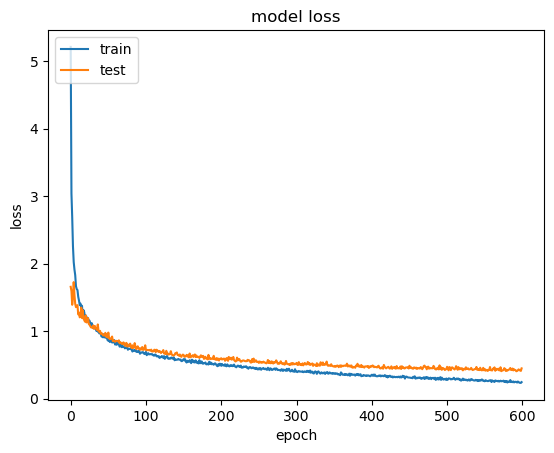

In [138]:
# Loss plotting
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

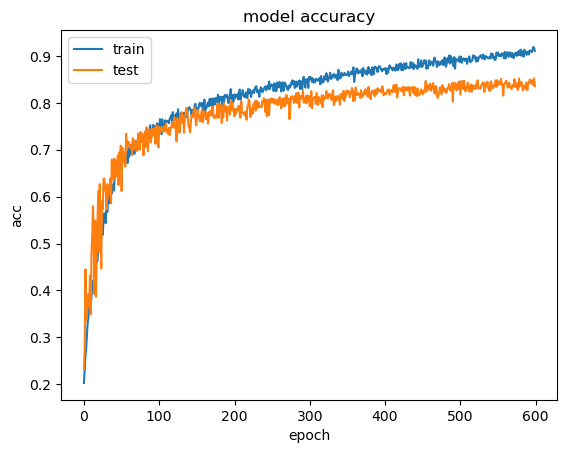

In [139]:
# Accuracy plotting
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [140]:
# Load Model
model = load_model('Audio_Sentiment_Model.h5')

In [141]:
df = df.loc[~df['emotion'].isin([5, 6])]
df = df.reset_index(drop=True)
feature_df = pd.DataFrame(df['feature'].values.tolist())
x = np.expand_dims(feature_df, axis=2)
preds = model.predict(x)

128/128 [==============================] - 2s 17ms/step


We can have a look at which emotions are being wrongly guessed.

In [143]:
pred_labels = np.argmax(preds, axis=1)
pred_df = pd.DataFrame({'prediction':pred_labels})
result_df = pd.concat([df, pred_df], axis=1)

# Count occurrences of each emotion
emotion_counts = result_df['emotion'].value_counts()

# Count occurrences of wrong predictions
wrong_predictions = result_df[result_df['emotion'] != result_df['prediction']]
wrong_prediction_counts = wrong_predictions['emotion'].value_counts()

# Create a new DataFrame for emotion, occurrences, and wrong predictions
counts_df = pd.DataFrame({'emotion': emotion_counts.index, 
                          'occurrences': emotion_counts.values, 
                          'wrong predictions': wrong_prediction_counts.values,
                          'percentage': wrong_prediction_counts.values / emotion_counts.values * 100})

counts_df['emotion'] = counts_df['emotion'].map(lambda x : get_emotion_str(int(x)))
counts_df

,emotion,occurrences,wrong predictions,percentage
0,neutral,964,118,12.240664
1,sad,776,118,15.206186
2,fearful,776,48,6.185567
3,angry,776,33,4.252577
4,happy,776,31,3.994845


We can look at which correct-wrong pairs are being guessed most.

In [146]:
# Count the occurrences of each 'actual-wrong' pair
correct_wrong_counts = wrong_predictions.groupby(['emotion', 'prediction']).size().reset_index(name='count')
correct_wrong_counts['emotion'] = correct_wrong_counts['emotion'].map(lambda x : get_emotion_str(x))
correct_wrong_counts['prediction'] = correct_wrong_counts['prediction'].map(lambda x : get_emotion_str(x))
correct_wrong_counts = correct_wrong_counts.sort_values(by=['count'], ascending=False)

correct_wrong_counts

,emotion,prediction,count
7,sad,neutral,73
15,fearful,happy,48
14,fearful,neutral,36
12,angry,happy,29
4,happy,neutral,22
10,sad,fearful,19
16,fearful,sad,19
8,sad,happy,19
0,neutral,happy,18
17,fearful,angry,15


It looks like the fearful-sad pair occurs a lot. Perhaps we can understand better if we know if the emotion was normal or strong.

We can look at it predicts different emotions whether it was labelled as strong or normal.

In [ ]:
# TODO:

Additionally, we can see if there's an effect on the model whether the audio clip was speech or song.

In [ ]:
# TODO: